In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>ilter
"""))
display(HTML("<style>div.output_scroll { height: 200em; }</style>"))


In [2]:
pwd

'/lustre/aoc/projects/hera/hgarsden'

In [3]:
ls *ipynb

PaperPlots-IDR2_2_437335.ipynb
PaperPlots-IDR2_2_437336.ipynb
PaperPlots-IDR2_2_437495.ipynb
PaperPlots-IDR2_2_437503.ipynb
PaperPlots-IDR2_2_437626.ipynb
PaperPlots-IDR2_2_437635.ipynb
PaperPlots-IDR2_2_463719.ipynb
PaperPlots-IDR2_2_463726.ipynb
PaperPlots-IDR2_2_478159.ipynb
PaperPlots-IDR2_2_518135.ipynb
PaperPlots-IDR2_2_555380.ipynb
PaperPlots-IDR2_2_570782.ipynb
PaperPlots-IDR2_2.ipynb
PaperPlots-IDR2_2_orig.ipynb
PaperPlots-IDR2_2_out.ipynb
PaperPlots-IDR2_2_sim_to_match_orig.ipynb
PaperPlots-null_test_for_histed_noise_dominated_bandpowers.ipynb
PaperPlots-null_test_for_histed_noise_dominated_bandpowers_orig.ipynb
PaperPlots-null_test_for_histed_noise_dominated_bandpowers_out.ipynb
Untitled.ipynb
view.ipynb


In [4]:
import sys
sys.path.append("/users/hgarsden/.local/lib/python3.9/site-packages")

In [5]:
%matplotlib inline
#%load_ext line_profiler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import hera_cal as hc
import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from pyuvdata import UVData, UVCal, UVFlag, utils as uvutils
from scipy import stats, signal, interpolate
import copy
import matplotlib.gridspec as gridspec
from astropy import constants
import uvtools as uvt
import cycler
import itertools
import os
from collections import OrderedDict as odict

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [7]:
import matplotlib.ticker as ticker

In [8]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [9]:
import matplotlib.font_manager

sim_file = "fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5"

### noise error bar

In [10]:
# LST binned, Inpainted & xtalk subtracted files
root = "/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/data/"
dfiles = sorted(glob.glob(root + "zen.grp1.of1.LST.1*.HH.OCRSLP2X.uvh5"))
dfiles[5] = sim_file

In [11]:
uvd_ = UVData()
print(dfiles[5])
uvd_.read(dfiles[5], read_data=False)

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


Telescope hera_sim is not in known_telescopes.


In [12]:
ntimes = 60      # Use this many
times = np.unique(uvd_.time_array)
time_range = (times[times.size//2-ntimes//2], times[times.size//2+ntimes//2-1])

xants = [0,2,11,24,50,53,54,67,69,98,122,136,139]

In [13]:
# short baseline group
bl_len_range = (14, 15)
bl_deg_range = (0, 1)
reds, lens, angs = hp.utils.get_reds(uvd_, bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, xants=xants)
bls = hp.utils.flatten(reds)

In [14]:
#uvd_.get

In [15]:
print(dfiles[5])
uvd_.read(dfiles[5], time_range=time_range, antenna_nums=np.array(bls).flatten(), polarizations=['xx','yy'])

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


In [16]:
beam = hp.PSpecBeamUV("/lustre/aoc/projects/hera/nkern/beams/NF_HERA_IQ_power_beam_healpix128.fits")

In [17]:
uvd = hp.pstokes.construct_pstokes(uvd_, uvd_, pstokes='pI')

In [18]:
# pspec at cross time, short baseline group
print("bl range for pI_shortbl", bl_len_range)

hp.pspecdata.pspec_run([copy.deepcopy(uvd)], 'pspec_nulltest.h5', groupname='pI_shortbl', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='autos', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

print()

bl range for pI_shortbl (14, 15)


Casting complex values to real discards the imaginary part


In [19]:
# intermediate baseline group
bl_len_range = (40, 45)
bl_deg_range = (0, 1)
reds, lens, angs = hp.utils.get_reds(uvd_, bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, xants=xants)
bls = hp.utils.flatten(reds)

In [20]:
# pspec at cross time, med baseline group
print("bls range for pI_medbl", bl_len_range)

hp.pspecdata.pspec_run([copy.deepcopy(uvd)], 'pspec_nulltest.h5', groupname='pI_medbl', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='autos', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)
                       
print()

bls range for pI_medbl (40, 45)


Casting complex values to real discards the imaginary part


### foreground_dependent error bar

In [21]:
# LST binned, Inpainted & xtalk subtracted files
root = "/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/data/"
dfiles = sorted(glob.glob(root + "zen.grp1.of1.LST.1*.HH.OCRSLP2X.uvh5"))
dfiles[5] = sim_file

In [22]:
dfiles[5]

'fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5'

In [23]:
uvd_ = UVData()
print(dfiles[5])
uvd_.read(dfiles[5], read_data=False)

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


Telescope hera_sim is not in known_telescopes.


In [24]:
xants = [0,2,11,24,50,53,54,67,69,98,122,136,139]

In [25]:
# short baseline group
bl_len_range = (14, 15)
bl_deg_range = (0, 1)
reds, lens, angs = hp.utils.get_reds(uvd_, bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, xants=xants)
bls = hp.utils.flatten(reds)

In [26]:
refcal = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/data/zen.grp1.of1.LST.1.50345.HH.OCRSLP2.allspws.refcal_smooth.calfits'

In [27]:
# intermediate baseline group
#bl_len_range = (40, 45)
#bl_deg_range = (0, 1)
#reds, lens, angs = hp.utils.get_reds(uvd_, bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, xants=xants)
#bls = hp.utils.flatten(reds)

In [28]:
print(dfiles[5])
uvd_.read(dfiles[5], time_range=time_range, antenna_nums=np.array(bls).flatten(), polarizations=['xx','yy'])

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


### some parameters

In [29]:
print(np.mean(np.diff(np.unique(uvd_.time_array)))*24*3600)

21.48000037266036


In [30]:
print(np.mean(np.diff(np.unique(uvd_.lst_array)))*24*3600/2/np.pi)

21.538810908041622


In [31]:
np.unique(uvd_.lst_array)[0]/2/np.pi*24, np.unique(uvd_.lst_array)[-1]/2/np.pi*24

(8.55777389548382, 8.9107710742545)

In [32]:
uvd_.Ntimes

60

In [33]:
uvd_.integration_time

array([21.4799881, 21.4799881, 21.4799881, ..., 21.4799881, 21.4799881,
       21.4799881])

In [34]:
np.mean(uvd_.integration_time), 

(21.47998809814453,)

In [35]:
uvcal_ref = UVCal()
uvcal_ref.read_calfits(refcal)

telescope_location is not set. Using known values for HERA.
antenna_positions is not set. Using known values for HERA.


In [36]:
uvd_PXC_ = uvd_ #uvutils.uvcalibrate(uvd_, uvcal_ref, inplace=False, prop_flags=True, flag_missing=False)

In [37]:
uvd_PXC =hp.pstokes.construct_pstokes(uvd_PXC_, uvd_PXC_, pstokes='pI')

In [38]:
uvd = hp.pstokes.construct_pstokes(uvd_, uvd_, pstokes='pI')

In [39]:
beam = hp.PSpecBeamUV("/lustre/aoc/projects/hera/nkern/beams/NF_HERA_IQ_power_beam_healpix128.fits")

get the differenced visibility

In [40]:
uvd1 = uvd.select(times=np.unique(uvd.time_array)[0:-1:2],inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2],inplace=False)
uvd_td = copy.deepcopy(uvd1)
uvd_td.data_array = (uvd2.data_array - uvd1.data_array)/np.sqrt(2)

In [41]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_td)], 'pspec_crosstime.h5', groupname='pI_shortbl_timediff', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=False, interleave_times=False, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [42]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd)], 'pspec_crosstime.h5', groupname='pI_shortbl', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='foreground_dependent', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [43]:
psc = hp.PSpecContainer('pspec_crosstime.h5', mode='rw', keep_open=True)
uvp_cov_fg = psc.get_pspec('pI_shortbl', 'dset0_x_dset1')

In [44]:
auto_Tsys = hp.utils.uvd_to_Tsys(uvd, beam)
hp.utils.uvp_noise_error(uvp_cov_fg, auto_Tsys, err_type=['P_N','P_SN'])

In [45]:
psc.set_pspec('pI_shortbl', 'dset0_x_dset1', uvp_cov_fg, overwrite=True)

## load power spectra

In [46]:
psc = hp.PSpecContainer('pspec_crosstime.h5', keep_open=False)
uvp_cov_fg = psc.get_pspec('pI_shortbl', 'dset0_x_dset1')
uvp_td = psc.get_pspec('pI_shortbl_timediff', 'dset0_x_dset0')

In [47]:
psc_ = hp.PSpecContainer('pspec_nulltest.h5', keep_open=False)
uvp_cov_n = psc_.get_pspec('pI_shortbl', 'dset0_x_dset1')

In [48]:
delay_resolution = 1 / (uvp_cov_fg.freq_array[-1]-uvp_cov_fg.freq_array[0])*1e9

#### other systematics

PXC

In [49]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_PXC)], 'pspec_systematics.h5', groupname='pI_shortbl_fg_PXC', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='foreground_dependent', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [50]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_PXC)], 'pspec_systematics.h5', groupname='pI_shortbl_noise_PXC', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='autos', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


P and PC

In [51]:
# LST binned, Inpainted files
root = "/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/data/"
dfiles = sorted(glob.glob(root + "zen.grp1.of1.LST.1*.HH.OCRSLP2.uvh5"))
dfiles[5] = sim_file

In [52]:
dfiles[5]

'fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5'

In [53]:
uvd_P_ = UVData()
print(dfiles[5])
uvd_P_ .read(dfiles[5], read_data=False)

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


Telescope hera_sim is not in known_telescopes.


In [54]:
xants = [0,2,11,24,50,53,54,67,69,98,122,136,139]

In [55]:
# short baseline group
bl_len_range = (14, 15)
bl_deg_range = (0, 1)
reds, lens, angs = hp.utils.get_reds(uvd_P_, bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, xants=xants)
bls = hp.utils.flatten(reds)

In [56]:
refcal = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/data/zen.grp1.of1.LST.1.50345.HH.OCRSLP2.allspws.refcal_smooth.calfits'

In [57]:
print(dfiles[5])
uvd_P_.read(dfiles[5], time_range=time_range, antenna_nums=np.array(bls).flatten(), polarizations=['xx','yy'])

fringe_rate_filter/cleaned_sim_1000_256_noise.uvh5


In [58]:
uvcal_ref = UVCal()
uvcal_ref.read_calfits(refcal)

telescope_location is not set. Using known values for HERA.
antenna_positions is not set. Using known values for HERA.


In [59]:
uvd_PC_ = uvd_P_ #uvutils.uvcalibrate(uvd_P_, uvcal_ref, inplace=False, prop_flags=True, flag_missing=True)

In [60]:
uvd_PC =hp.pstokes.construct_pstokes(uvd_PC_, uvd_PC_, pstokes='pI')

In [61]:
uvd_P = hp.pstokes.construct_pstokes(uvd_P_, uvd_P_, pstokes='pI')

In [62]:
beam = hp.PSpecBeamUV("/lustre/aoc/projects/hera/nkern/beams/NF_HERA_IQ_power_beam_healpix128.fits")

In [63]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_P)], 'pspec_systematics.h5', groupname='pI_shortbl_fg_P', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='foreground_dependent', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [64]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_P)], 'pspec_systematics.h5', groupname='pI_shortbl_noise_P', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='autos', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [65]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_PC)], 'pspec_systematics.h5', groupname='pI_shortbl_fg_PC', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='foreground_dependent', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


In [66]:
# pspec at cross time
hp.pspecdata.pspec_run([copy.deepcopy(uvd_PC)], 'pspec_systematics.h5', groupname='pI_shortbl_noise_PC', spw_ranges=[(0, 180)],
                       dset_pairs=[(0,0)], pol_pairs=['pI'], input_data_weight='identity', norm='I',
                       rephase_to_dset=True, interleave_times=True, Jy2mK=True, overwrite=True, verbose=False,
                       bl_len_range=bl_len_range, bl_deg_range=bl_deg_range, beam=beam, taper='bh',
                       broadcast_dset_flags=True, time_thresh=0.99, store_cov_diag=True, cov_model='autos', 
                       exclude_auto_bls=True, exclude_cross_bls=False, exclude_permutations=True)

Casting complex values to real discards the imaginary part


### some parameters

In [67]:
uvp_cov_fg.Ntimes

30

In [68]:
np.unique(uvp_cov_fg.time_avg_array)

array([2458116.52588191, 2458116.52637913, 2458116.52687635,
       2458116.52737358, 2458116.5278708 , 2458116.52836802,
       2458116.52886524, 2458116.52936246, 2458116.52985969,
       2458116.53035691, 2458116.53085413, 2458116.53135135,
       2458116.53184857, 2458116.5323458 , 2458116.53284302,
       2458116.53334024, 2458116.53383746, 2458116.53433469,
       2458116.53483191, 2458116.53532913, 2458116.53582635,
       2458116.53632358, 2458116.5368208 , 2458116.53731802,
       2458116.53781524, 2458116.53831246, 2458116.53880969,
       2458116.53930691, 2458116.53980413, 2458116.54030135])

In [69]:
np.mean(np.diff(np.unique(uvp_cov_fg.time_avg_array)))*24*3600

42.9599997812304

In [70]:
np.mean(np.diff(np.unique(uvp_cov_fg.lst_avg_array)))/2/np.pi*24*3600

43.07762154491905

In [71]:
np.unique(uvp_cov_fg.lst_avg_array)/2/np.pi*24

array([8.5607654 , 8.57273141, 8.58469741, 8.59666342, 8.60862942,
       8.62059543, 8.63256144, 8.64452744, 8.65649345, 8.66845945,
       8.68042545, 8.69239147, 8.70435747, 8.71632347, 8.72828948,
       8.74025548, 8.75222149, 8.76418749, 8.7761535 , 8.78811951,
       8.80008551, 8.81205152, 8.82401752, 8.83598353, 8.84794954,
       8.85991554, 8.87188155, 8.88384755, 8.89581356, 8.90777957])

In [72]:
uvp_cov_fg.freq_array[-1]/1e6, uvp_cov_fg.freq_array[0]/1e6

(117.48046875, 100.0)

## make plots

In [73]:
key = uvp_cov_fg.get_all_keys()[0]
dlys = uvp_cov_fg.get_dlys(key[0]) * 1e9
kparas = uvp_cov_fg.get_kparas(key[0])
tau2k = (kparas/dlys)[0]

invalid value encountered in true_divide


In [74]:
len(uvp_cov_fg.get_all_keys())

276

In [75]:
print(key)

(0, ((12, 13), (13, 14)), ('pI', 'pI'))


In [76]:
def tau2k_(x):
    return x * tau2k
def k2tau_(x):
    return x / tau2k

In [77]:
from matplotlib.ticker import Locator
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

In [78]:
time_index = 0
# Dicts of colors
color_list = odict()
# Dicts of labels
label_list = odict()
# Dicts of error bars
error_list = odict()
linestyle_list = odict()

# The extra kinds of error bars
error_list['PSN'] = uvp_cov_fg.get_stats('P_SN', key)[time_index].real
label_list['PSN'] = r'$P_\mathrm{SN}$'
color_list['PSN'] = 'darkcyan' 
linestyle_list['PSN'] = "-"
error_list['PN'] = uvp_cov_fg.get_stats('P_N', key)[time_index].real
label_list['PN'] = r'$P_\mathrm{N}$'
color_list['PN'] = 'tomato' 
linestyle_list['PN'] = "-"
# The power spectra of time difference data as error bars in noise dominant regions, 
error_list['fg'] = uvp_cov_fg.get_stats('foreground_dependent_diag', key)[time_index].real
label_list['fg'] = r"$\sigma_\mathrm{QE-SN}$"
color_list['fg'] = 'limegreen' 
linestyle_list['fg'] = "-"
error_list['noise'] = uvp_cov_n.get_stats('autos_diag', key)[time_index].real
label_list['noise'] = r"$\sigma_\mathrm{QE-N}$"
color_list['noise'] = 'darkred' 
linestyle_list['noise'] = "-"
error_list['Pdiff'] = np.abs(uvp_td.get_data(key)[time_index].real)
color_list['Pdiff'] = 'orange' 
label_list['Pdiff'] = r'$P_\mathrm{diff}$'
linestyle_list['Pdiff'] = "-."
for error_type in error_list.keys():  
    error_list[error_type] = np.array(error_list[error_type]).reshape(-1)

# The power spectrum
ps = (uvp_cov_fg.get_data(key)[time_index].real).reshape(-1)

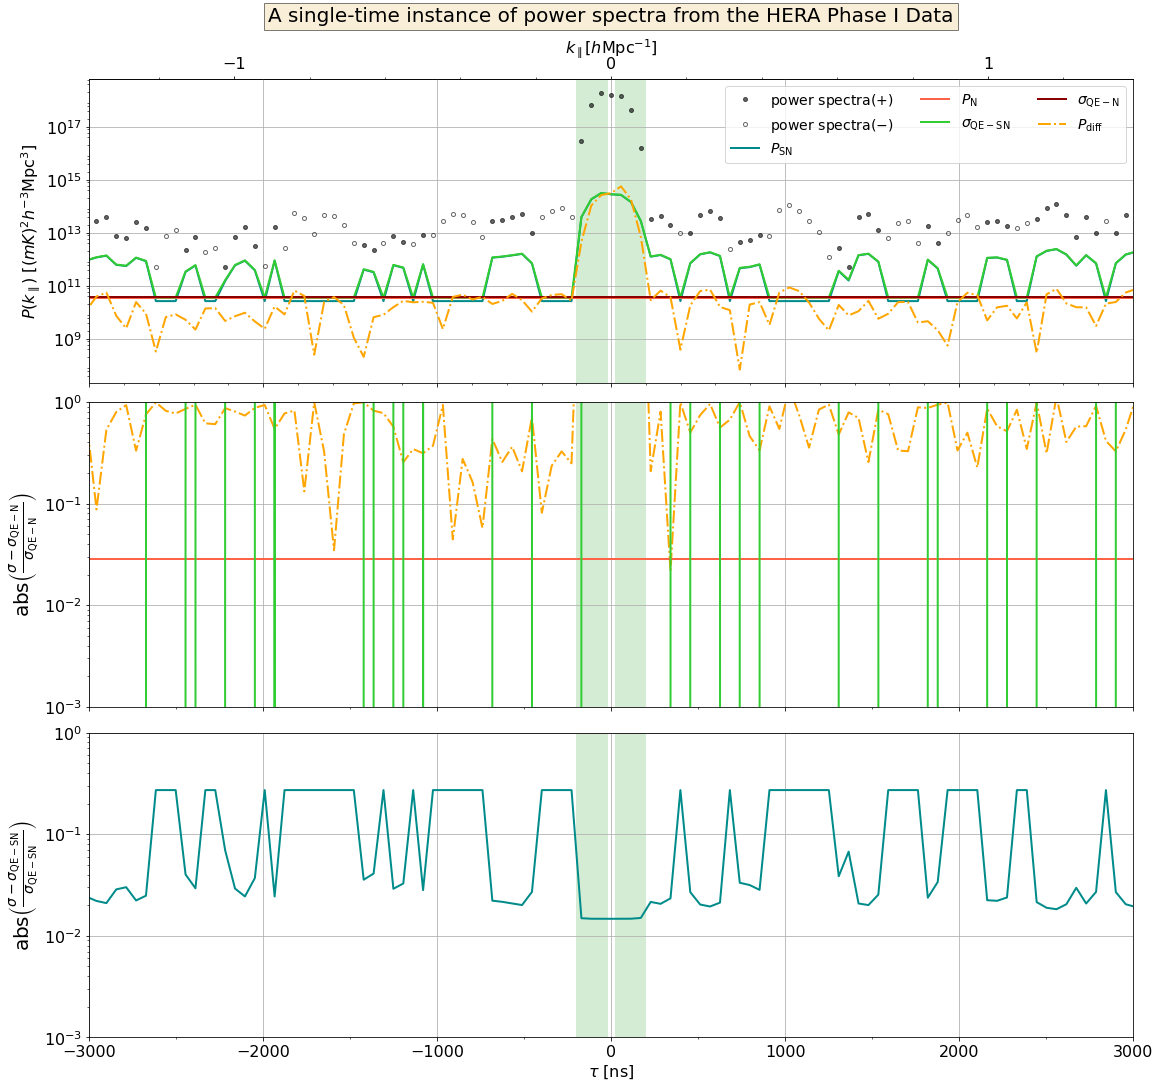

In [79]:
fig = plt.figure(figsize=(16,15), constrained_layout=True)
gs = fig.add_gridspec(3, 2, wspace=0.02)
psunits = uvp_cov_fg.units
if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
if "Mpc" in psunits and "\\rm" not in psunits: 
    psunits = psunits.replace("Mpc", r"{\rm Mpc}")
if "pi" in psunits and "\\pi" not in psunits: 
    psunits = psunits.replace("pi", r"\pi")
    
# Plot different kinds of error bars
ax = fig.add_subplot(gs[0,:])
ax.plot(dlys[ps>=0.], ps[ps>=0.], ".", label='power spectra'+ r'$(+)$', c='k', markersize=8, alpha = 0.6)
ax.plot(dlys[ps<0.], np.abs(ps[ps<0.]), ".", fillstyle='none', label='power spectra'+ r'$(-)$', c='k', markersize=8, alpha = 0.6)
ax.set_xlim(-3000,3000)
for error_type in error_list.keys():
    ax.plot(dlys, error_list[error_type], ls=linestyle_list[error_type],label=label_list[error_type], c=color_list[error_type], lw=2)
ax.set_ylabel("$P(k_\parallel)$ $[%s]$" % psunits, fontsize=16)
#ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=20)
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', labelsize=16)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.semilogy()
ax.minorticks_on()
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[0.2,0.4,0.6,0.8], numticks=20))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.grid()
ax.legend(loc='upper right', fontsize=14, ncol=3)
ax.set_title('A single-time instance of power spectra from the HERA Phase I Data', bbox=dict(fc='wheat', alpha=0.5), fontsize=20, pad=15)
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)

ax1 = ax.secondary_xaxis('top', functions=(tau2k_, k2tau_))
ax1.tick_params(axis='both', which='both', labelsize=16, direction='out')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax1.set_xlabel(r"$k_\parallel [h {\rm Mpc}^{-1}]$", fontsize=16)

#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.53,1.15), loc='upper center', fontsize=14, ncol=3,)
#fig.tight_layout()

# Plot ratios of different kinds of error bars
ax = fig.add_subplot(gs[1,:])
for error_type in ['Pdiff','PN','fg']:
    ax.plot(dlys, np.abs(error_list[error_type]/error_list['noise']-1), ls=linestyle_list[error_type],label=label_list[error_type], c=color_list[error_type], lw=2)
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', labelsize=16)
ax.grid()
ax.semilogy()
ax.set_ylim(1e-3,1)
ax.set_xlim(-3000,3000)
ax.set_ylabel("abs" + r"$\left(\frac{\sigma-\sigma_{\rm QE-N}}{\sigma_{\rm QE-N}}\right)$", fontsize=20)
#ax.yaxis.set_minor_locator(MinorSymLogLocator(0.01))
#ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)
ax.axhline(y=0, c='k', lw=3)

ax = fig.add_subplot(gs[2,:])
for error_type in ['PSN']:
    ax.plot(dlys, np.abs(error_list[error_type]/error_list['fg']-1), ls=linestyle_list[error_type], label=label_list[error_type], c=color_list[error_type], lw=2)
ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.grid()
ax.set_xlim(-3000,3000)
ax.semilogy()
ax.set_ylim(1e-3,1)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_ylabel("abs" + r"$\left(\frac{\sigma-\sigma_{\rm QE-SN}}{\sigma_{\rm QE-SN}}\right)$", fontsize=20)
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)
ax.axhline(y=0, c='k', lw=3)

get the time average

In [80]:
new_stats_array = odict()
new_stats_array.update({'Pdiff_err': {0: np.abs(uvp_td.data_array[0].real)}})
new_stats_array.update(uvp_cov_fg.stats_array)

In [81]:
uvp_cov_fg.stats_array = new_stats_array

In [82]:
print(uvp_cov_fg.Ntimes)

30


In [83]:
uvp_cov_fg_uni = uvp_cov_fg.average_spectra(time_avg=True, error_weights=None, error_field=['Pdiff_err',"foreground_dependent_diag", "P_N","P_SN"],
                              inplace=False)

In [84]:
uvp_cov_n_uni = uvp_cov_n.average_spectra(time_avg=True, error_weights=None, error_field=["autos_diag"], inplace=False)

In [85]:
key = uvp_cov_fg_uni.get_all_keys()[0]
error_tavg_list = odict()
error_tavg_list['PSN'] = uvp_cov_fg_uni.get_stats('P_SN', key)[0].real
error_tavg_list['PN'] = uvp_cov_fg_uni.get_stats('P_N', key)[0].real
error_tavg_list['fg'] = uvp_cov_fg_uni.get_stats('foreground_dependent_diag', key)[0].real
error_tavg_list['noise'] = uvp_cov_n_uni.get_stats('autos_diag', key)[0].real
error_tavg_list['Pdiff'] = uvp_cov_fg_uni.get_stats('Pdiff_err', key)[0].real
# The power spectrum
ps_tavg = (uvp_cov_fg_uni.get_data(key)[0].real).reshape(-1)

bootstrap

In [86]:
boots = []
spectra = uvp_cov_fg.get_data(key)
for i in range(2000):
    _select = np.random.choice(np.arange(spectra.shape[0]), spectra.shape[0], replace=True)
    boots.append(np.mean(spectra[_select,:], axis=0))
error_tavg_list['boot'] = np.std(np.real(boots), axis=0)

In [87]:
label_list['boot'] = r"$\sigma_\mathrm{bs}$"
color_list['boot'] = 'indigo'
linestyle_list['boot'] = '-.'

In [88]:
for error_type in error_tavg_list.keys():  
    error_tavg_list[error_type] = np.array(error_tavg_list[error_type]).reshape(-1)

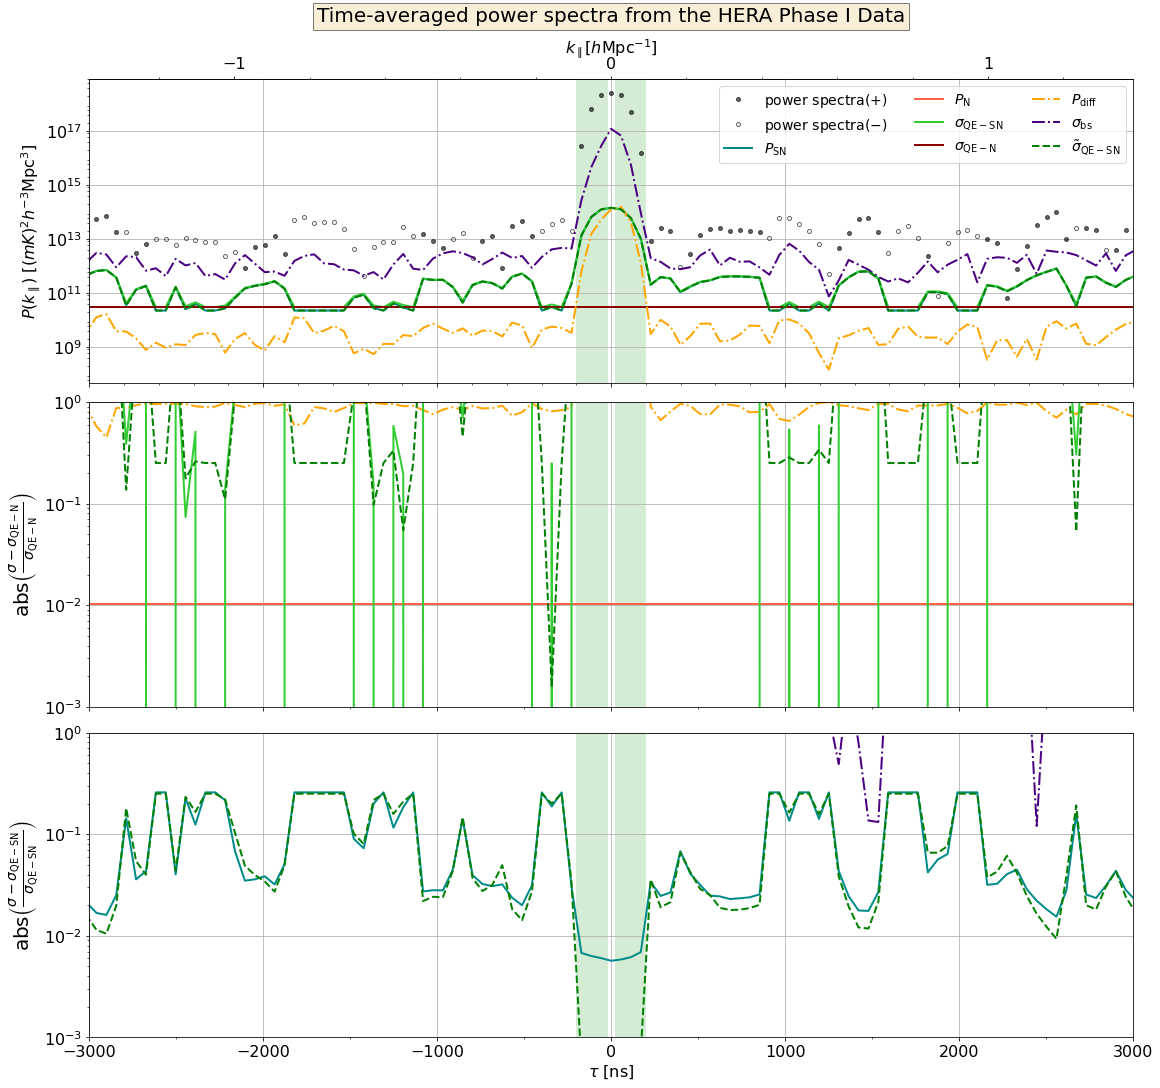

In [89]:
fig = plt.figure(figsize=(16,15), constrained_layout=True)
gs = fig.add_gridspec(3, 2, wspace=0.02)
psunits = uvp_cov_fg.units
if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
if "Mpc" in psunits and "\\rm" not in psunits: 
    psunits = psunits.replace("Mpc", r"{\rm Mpc}")
if "pi" in psunits and "\\pi" not in psunits: 
    psunits = psunits.replace("pi", r"\pi")
    
# Plot different kinds of error bars
ax = fig.add_subplot(gs[0,:])
ax.plot(dlys[ps_tavg>=0.], ps_tavg[ps_tavg>=0.], ".", label='power spectra'+ r'$(+)$', c='k', markersize=8, alpha = 0.6)
ax.plot(dlys[ps_tavg<0.], np.abs(ps_tavg[ps_tavg<0.]), ".", fillstyle='none', label='power spectra'+ r'$(-)$', c='k', markersize=8, alpha = 0.6)
ax.set_xlim(-3000,3000)
for error_type in error_tavg_list.keys():
    ax.plot(dlys, error_tavg_list[error_type], ls=linestyle_list[error_type],label=label_list[error_type], c=color_list[error_type], lw=2)
error_modified_fg = error_tavg_list['fg']-(np.sqrt(1+1/np.sqrt(np.pi))-1)*error_tavg_list['noise']
ax.plot(dlys, error_modified_fg, label=r"$\tilde{\sigma}_\mathrm{QE-SN}$", c="green", ls="--", lw=2)
ax.set_ylabel("$P(k_\parallel)$ $[%s]$" % psunits, fontsize=16)
#ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=20)
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', labelsize=16)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.semilogy()
ax.minorticks_on()
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[0.2,0.4,0.6,0.8], numticks=20))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.grid()
ax.legend(loc='upper right', fontsize=14, ncol=3)
ax.set_title('Time-averaged power spectra from the HERA Phase I Data', bbox=dict(fc='wheat', alpha=0.5), fontsize=20, pad=15)
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)

ax1 = ax.secondary_xaxis('top', functions=(tau2k_, k2tau_))
ax1.tick_params(axis='both', which='both', labelsize=16, direction='out')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax1.set_xlabel(r"$k_\parallel [h {\rm Mpc}^{-1}]$", fontsize=16)

#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor=(0.53,1.15), loc='upper center', fontsize=14, ncol=3,)
#fig.tight_layout()

# Plot ratios of different kinds of error bars
ax = fig.add_subplot(gs[1,:])
for error_type in ['Pdiff','PN','fg','boot']:
    ax.plot(dlys, np.abs(error_tavg_list[error_type]/error_tavg_list['noise']-1), ls=linestyle_list[error_type], label=label_list[error_type], c=color_list[error_type], lw=2)
ax.plot(dlys, np.abs(error_modified_fg/error_tavg_list['noise']-1), label=r"$\tilde{\sigma}_\mathrm{QE-SN}$", c="green", ls="--", lw=2)
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', labelsize=16)
ax.grid()
ax.semilogy()
ax.set_ylim(1e-3,1)
ax.set_xlim(-3000,3000)
ax.set_ylabel("abs" + r"$\left(\frac{\sigma-\sigma_{\rm QE-N}}{\sigma_{\rm QE-N}}\right)$", fontsize=20)
#ax.yaxis.set_minor_locator(MinorSymLogLocator(0.01))
#ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)
ax.axhline(y=0, c='k', lw=3)

ax = fig.add_subplot(gs[2,:])
for error_type in ['PSN','boot']:
    ax.plot(dlys, np.abs(error_tavg_list[error_type]/error_tavg_list['fg']-1), ls=linestyle_list[error_type], label=label_list[error_type], c=color_list[error_type], lw=2)
ax.plot(dlys, np.abs(error_modified_fg/error_tavg_list['fg']-1), label=r"$\tilde{\sigma}_\mathrm{QE-SN}$", c="green", ls="--", lw=2)
ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.grid()
ax.set_xlim(-3000,3000)
ax.semilogy()
ax.set_ylim(1e-3,1)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_ylabel("abs" + r"$\left(\frac{\sigma-\sigma_{\rm QE-SN}}{\sigma_{\rm QE-SN}}\right)$", fontsize=20)
ax.axvspan(-200, -20, facecolor='#2ca02c', alpha=0.2)
ax.axvspan(20, 200, facecolor='#2ca02c', alpha=0.2)
ax.axhline(y=0, c='k', lw=3)

#### comparing systematics

In [90]:
psc = hp.PSpecContainer('pspec_crosstime.h5', keep_open=False)
uvp_PX_cov_fg = psc.get_pspec('pI_shortbl', 'dset0_x_dset1')

In [91]:
# load power spectra
psc_ = hp.PSpecContainer('pspec_nulltest.h5', keep_open=False)
uvp_PX_cov_n = psc_.get_pspec('pI_shortbl', 'dset0_x_dset1')

In [92]:
psc = hp.PSpecContainer('pspec_systematics.h5', keep_open=False)

In [93]:
uvp_P_cov_fg = psc.get_pspec('pI_shortbl_fg_P', 'dset0_x_dset1')
uvp_P_cov_n = psc.get_pspec('pI_shortbl_noise_P', 'dset0_x_dset1')

In [94]:
uvp_PC_cov_fg = psc.get_pspec('pI_shortbl_fg_PC', 'dset0_x_dset1')
uvp_PC_cov_n = psc.get_pspec('pI_shortbl_noise_PC', 'dset0_x_dset1')

In [95]:
uvp_PXC_cov_fg = psc.get_pspec('pI_shortbl_fg_PXC', 'dset0_x_dset1')
uvp_PXC_cov_n = psc.get_pspec('pI_shortbl_noise_PXC', 'dset0_x_dset1')

check match in timestamps

In [96]:
print(np.unique(uvp_P_cov_fg.lst_avg_array))

[2.24120314 2.24433583 2.24746853 2.25060122 2.25373391 2.2568666
 2.2599993  2.26313199 2.26626468 2.26939738 2.27253007 2.27566276
 2.27879546 2.28192815 2.28506084 2.28819354 2.29132623 2.29445892
 2.29759161 2.30072431 2.303857   2.30698969 2.31012239 2.31325508
 2.31638777 2.31952047 2.32265316 2.32578585 2.32891855 2.33205124]


In [97]:
print(np.unique(uvp_PX_cov_fg.lst_avg_array))

[2.24120314 2.24433583 2.24746853 2.25060122 2.25373391 2.2568666
 2.2599993  2.26313199 2.26626468 2.26939738 2.27253007 2.27566276
 2.27879546 2.28192815 2.28506084 2.28819354 2.29132623 2.29445892
 2.29759161 2.30072431 2.303857   2.30698969 2.31012239 2.31325508
 2.31638777 2.31952047 2.32265316 2.32578585 2.32891855 2.33205124]


In [98]:
print(np.unique(uvp_PC_cov_fg.lst_avg_array))

[2.24120314 2.24433583 2.24746853 2.25060122 2.25373391 2.2568666
 2.2599993  2.26313199 2.26626468 2.26939738 2.27253007 2.27566276
 2.27879546 2.28192815 2.28506084 2.28819354 2.29132623 2.29445892
 2.29759161 2.30072431 2.303857   2.30698969 2.31012239 2.31325508
 2.31638777 2.31952047 2.32265316 2.32578585 2.32891855 2.33205124]


In [99]:
print(np.unique(uvp_PXC_cov_fg.lst_avg_array))

[2.24120314 2.24433583 2.24746853 2.25060122 2.25373391 2.2568666
 2.2599993  2.26313199 2.26626468 2.26939738 2.27253007 2.27566276
 2.27879546 2.28192815 2.28506084 2.28819354 2.29132623 2.29445892
 2.29759161 2.30072431 2.303857   2.30698969 2.31012239 2.31325508
 2.31638777 2.31952047 2.32265316 2.32578585 2.32891855 2.33205124]


#### inpainted data

beyond 3sigma 0.4956772334293947 Gauss 0.002428115998334692 Laplacian 0.013579845438731157


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.48684210526315796 Gauss 0.0024281159983350594 Laplacian 0.005948061672799176


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.4708737864077668 Gauss 0.0024281159983352866 Laplacian 0.004149607025079594
30084


FixedFormatter should only be used together with FixedLocator


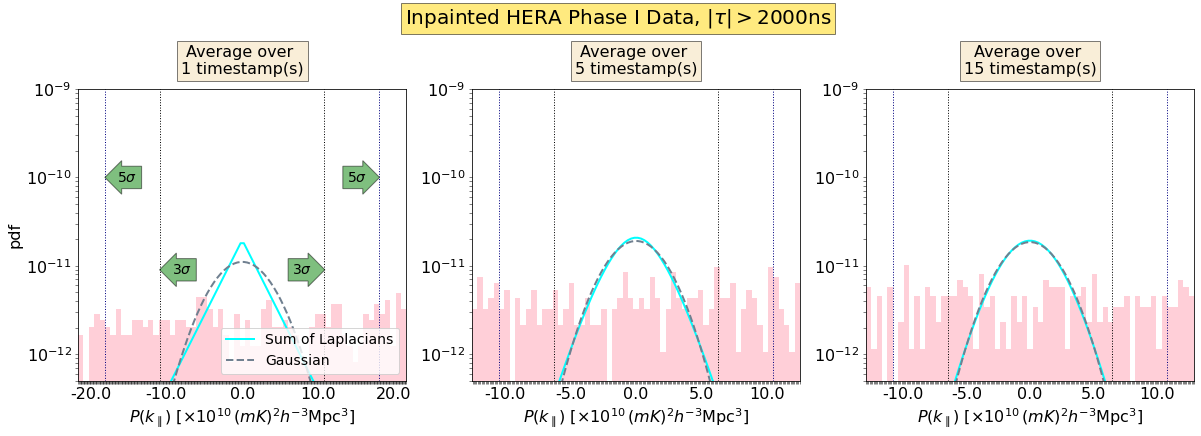

In [100]:
# used in paper
# A larger window (2000), with normalization
uvp_plot = uvp_P_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere(dlys< -2000), np.argwhere(dlys> 2000))
suptitle = "Inpainted HERA Phase I Data, "+r"$|\tau|>2000 {\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacians", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma), \
          "Gauss {}".format((np.sum(Gauss_curve)-np.sum(Gauss_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Gauss_curve)), \
          "Laplacian {}".format((np.sum(Lap_curve)-np.sum(Lap_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Lap_curve)))
    
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

beyond 3sigma 0.46428571428571463 Gauss 0.002428115998334692 Laplacian 0.013579845438731157


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.46835443037974694 Gauss 0.0024281159983350594 Laplacian 0.005948061672799176


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.4929577464788732 Gauss 0.0024281159983352866 Laplacian 0.004149607025079594
9936


FixedFormatter should only be used together with FixedLocator


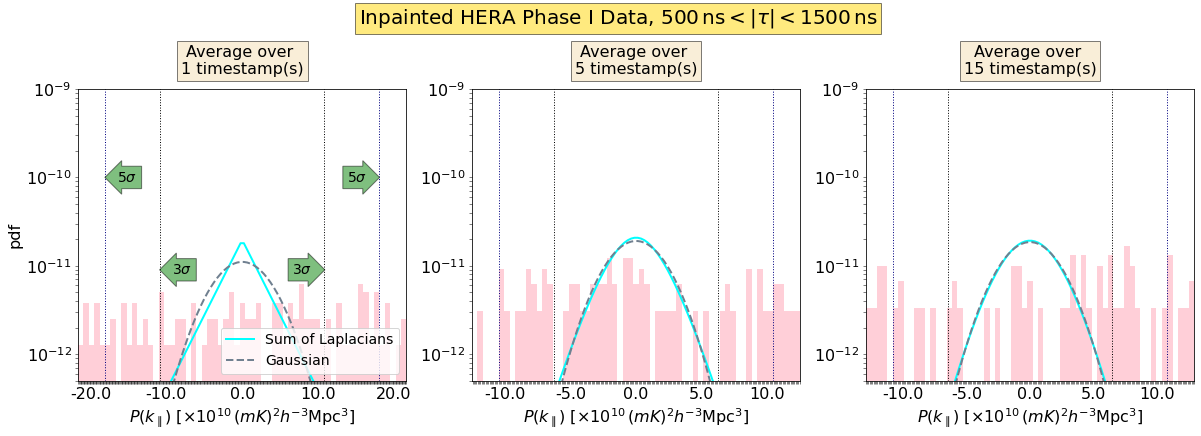

In [101]:
# used in paper
# A larger window (500-1500), with normalization
uvp_plot = uvp_P_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere((dlys< -500)*(dlys>-1500)), np.argwhere((dlys< 1500)*(dlys>500)))
suptitle = "Inpainted HERA Phase I Data, " + r"$500\,{\rm ns}<|\tau|<1500\,{\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacians", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma), \
          "Gauss {}".format((np.sum(Gauss_curve)-np.sum(Gauss_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Gauss_curve)), \
          "Laplacian {}".format((np.sum(Lap_curve)-np.sum(Lap_curve[(-3*Gauss_sigma<=px)*(px<=3*Gauss_sigma)]))/np.sum(Lap_curve)))
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

#### inpainted + reflection

beyond 3sigma 0.4956772334293947


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.48684210526315796


FixedFormatter should only be used together with FixedLocator


beyond 3sigma 0.4708737864077668
30084


FixedFormatter should only be used together with FixedLocator


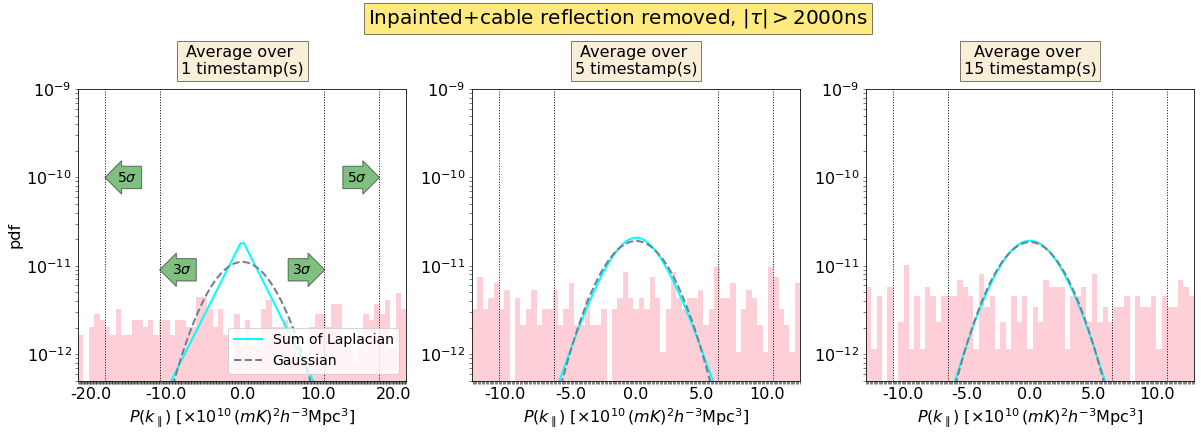

In [102]:
# used in paper
# A larger window (2000), with normalization
uvp_plot = uvp_PC_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere(dlys< -2000), np.argwhere(dlys> 2000))
suptitle = "Inpainted+cable reflection removed, "+r"$|\tau|>2000 {\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="Sum of Laplacian", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    bins_center = (bins_edge[1:] + bins_edge[0:-1])/2
    outlier_3sigma = (np.sum(n_in_bins)-np.sum(n_in_bins[(-3*Gauss_sigma<=bins_center)*(bins_center<=3*Gauss_sigma)]))/np.sum(n_in_bins)
    print("beyond 3sigma {}".format(outlier_3sigma))
    
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


9936


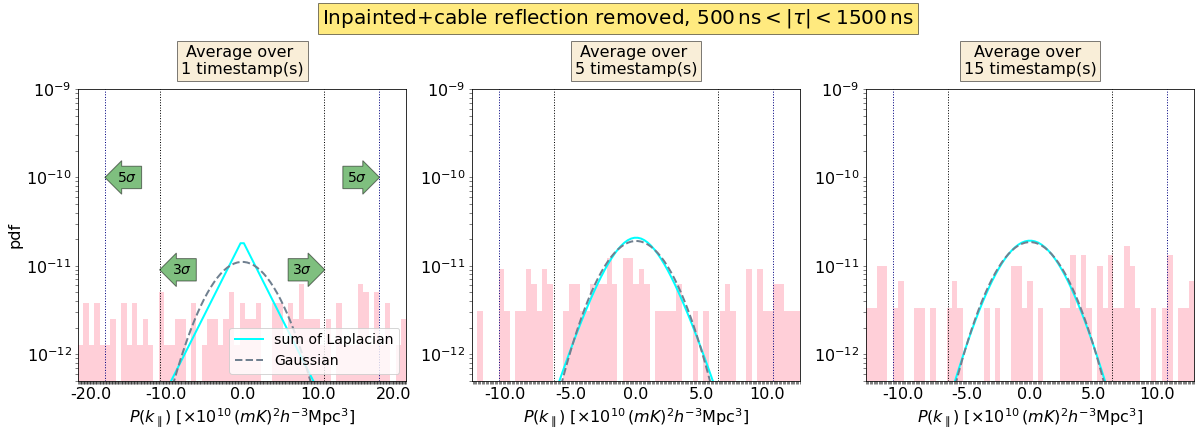

In [103]:
# used in paper
# A larger window (500-1500), with normalization
uvp_plot = uvp_PC_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere((dlys< -500)*(dlys>-1500)), np.argwhere((dlys< 1500)*(dlys>500)))
suptitle = "Inpainted+cable reflection removed, " + r"$500\,{\rm ns}<|\tau|<1500\,{\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="sum of Laplacian", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

#### inpainted + xtalk + reflection

FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


30084


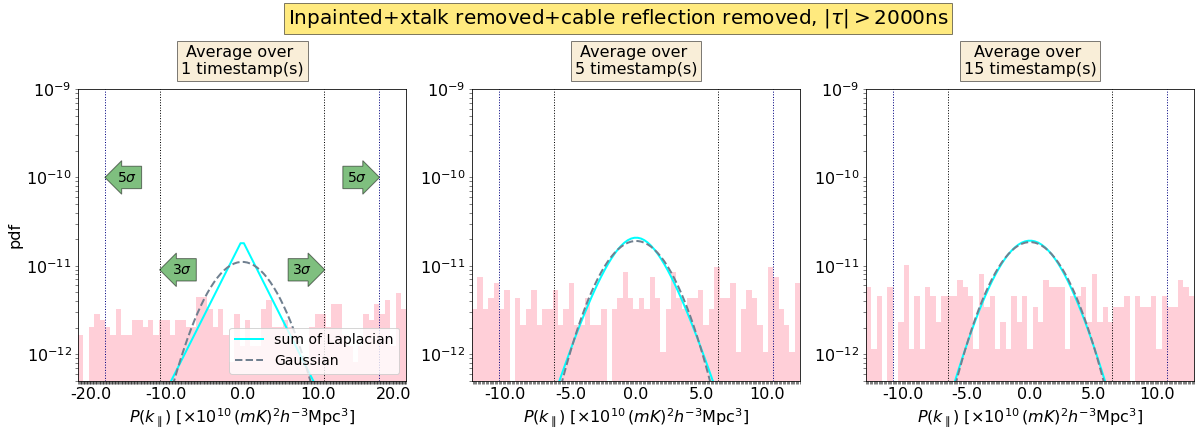

In [104]:
# used in paper
# A larger window (2000), with normalization
uvp_plot = uvp_PXC_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere(dlys< -2000), np.argwhere(dlys> 2000))
suptitle = "Inpainted+xtalk removed+cable reflection removed, "+r"$|\tau|>2000 {\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="sum of Laplacian", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))

FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


FixedFormatter should only be used together with FixedLocator


9936


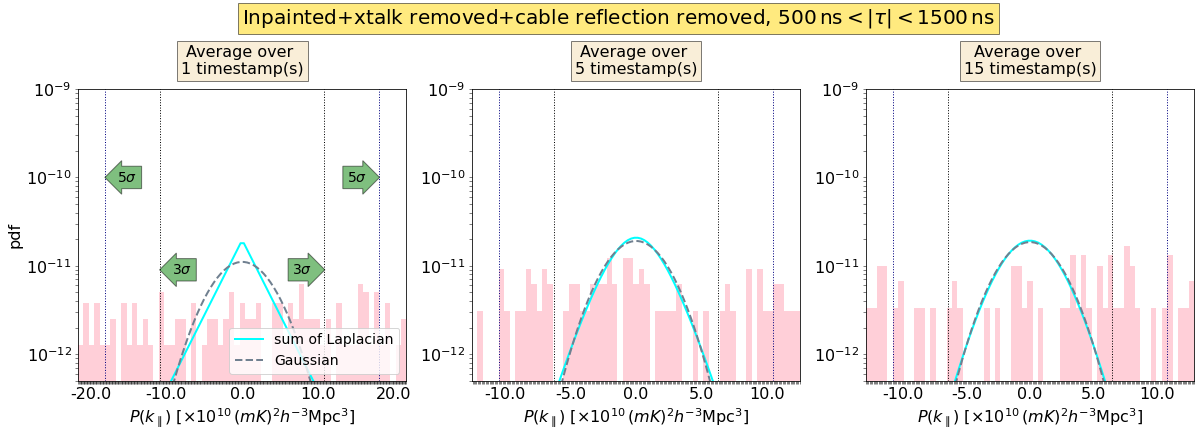

In [105]:
# used in paper
# A larger window (500-1500), with normalization
uvp_plot = uvp_PXC_cov_n
num_time_samples_list = [1,5,15]
ylim = (5*1e-13,1e-9)
dlys = uvp_plot.get_dlys(0) * 1e9
delay_args = np.append(np.argwhere((dlys< -500)*(dlys>-1500)), np.argwhere((dlys< 1500)*(dlys>500)))
suptitle = "Inpainted+xtalk removed+cable reflection removed, " + r"$500\,{\rm ns}<|\tau|<1500\,{\rm ns}$"

fig, axes = plt.subplots(figsize=(20,6), ncols=3, nrows=1)
for ax_idx, num_time_samples in enumerate(num_time_samples_list):
    col_idx = ax_idx%3
    times = np.arange(num_time_samples)
   
    # Get all keys
    keys = uvp_plot.get_all_keys()
    blpt_weights = np.array([[1. for item in times] for key in keys])
    ps_real_time_avg = []
    for dly in delay_args:
        ps = np.array([[uvp_plot.get_data(key)[time, dly]*uvp_plot.get_stats("autos_diag", keys[0])[time,0].real\
                        /uvp_plot.get_stats("autos_diag", key)[time, dly].real for time in times] for key in keys])
        ps_real_time_avg.extend((np.sum(ps.real*blpt_weights, axis=1)/np.sum(blpt_weights, axis=1).clip(1e-10, np.inf)).flatten())
    ps_real_time_avg = np.array(ps_real_time_avg) - np.mean(ps_real_time_avg)
    # The ratio of error bars to the original one
    psunits = uvp_plot.units
    if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
    if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
    if "Mpc" in psunits and "\\rm" not in psunits: 
        psunits = psunits.replace("Mpc", r"{\rm Mpc}")
    if "pi" in psunits and "\\pi" not in psunits: 
        psunits = psunits.replace("pi", r"\pi")
    
    ax = axes[col_idx]
    Lap_sigma_list = np.zeros(num_time_samples)
    for time in times:
        Lap_sigma_list[time] = uvp_plot.get_stats("autos_diag", keys[0])[time, 0].real 
    Gauss_sigma = np.sqrt(np.sum(Lap_sigma_list**2))/num_time_samples
    vlim = 6*Gauss_sigma
    n_in_bins, bins_edge, _ = ax.hist(ps_real_time_avg, log=True, density=True, bins=61, range=(-vlim, vlim), alpha=0.75,
                           color='pink')
    ax.set_xlim(-vlim, vlim)
    ax.set_ylim(*ylim)
    
    px = np.linspace(-vlim, vlim, 100)
    Lap_curve = np.zeros_like(px)
    normalized_factor = 0
    for time in times:
        scale_factor = 1
        for time_ in times:
            if time_ != time:
                scale_factor *= Lap_sigma_list[time]**2/(Lap_sigma_list[time]**2-Lap_sigma_list[time_]**2)
        normalized_factor += scale_factor   
        Lap_curve += np.exp(-np.sqrt(2)*np.abs(px)/Lap_sigma_list[time]*num_time_samples)/np.sqrt(2)/Lap_sigma_list[time]*num_time_samples*scale_factor
    
    # Calculate the equivalent Gaussian pdf
    Gauss_curve = np.exp(-px**2/2/Gauss_sigma**2)/np.sqrt(2*np.pi*Gauss_sigma**2)
    
    if np.isclose(normalized_factor,1,rtol=5e-1):
        ax.plot(px, Lap_curve, ls='-', lw=2, label="sum of Laplacian", c='cyan')
    ax.plot(px, Gauss_curve, ls='--', lw=2, label='Gaussian', c='slategrey')
    
    # confidence interval
    ax.axvline(x=3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=-3*Gauss_sigma, c='k', lw=1, ls=':')
    ax.axvline(x=5*Gauss_sigma, c='navy', lw=1, ls=':')
    ax.axvline(x=-5*Gauss_sigma, c='navy', lw=1, ls=':')
    if ax_idx == 0:
        ax.text(2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="rarrow", fc="green", alpha=0.5))
        ax.text(-2.2*Gauss_sigma, 9*1e-12, r'$3 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
        ax.text(-4.2*Gauss_sigma, 1e-10, r'$5 \sigma$', ha="center", va="center", rotation=0,
            fontsize=14,
            bbox=dict(boxstyle="larrow", fc="green", alpha=0.5))
    
    ax.tick_params(which='both', labelsize=16, length=3, width=0.5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e9))
    xticks = ax.get_xticks()
    ax.set_xticklabels(xticks/1e10)
    ax.set_xlabel("$P(k_\parallel)$ $[\\times 10^{10}\,%s]$" % psunits, fontsize=16)
    if col_idx == 0: 
        ax.set_ylabel("pdf", fontsize=16)
    if ax_idx == 0:
        ax.legend(loc='lower right', fontsize=14)
    ax.set_title("Average over \n{} timestamp(s)".format(num_time_samples),bbox=dict(fc='wheat', alpha=0.5), fontsize=16, pad=15)
fig.subplots_adjust(top=0.8)
fig.suptitle(suptitle, fontsize=20, bbox=dict(fc='gold', alpha=0.5), x=0.5, y=0.99)
print(len(uvp_plot.get_all_keys())*len(delay_args))